In [16]:
import sys
sys.path.append("/Users/weizhang/Documents/_GIT/nyu-hedge-fund-strategies/nyu-hedge-fund-strategies")
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common import factor_distribution
from sharadar import equity_prices, fundamental_signal
from scipy.stats import pearsonr

In [2]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
universe = quandl.get_table('SHARADAR/SP500', action='historical', date='2022-12-31')

In [3]:
fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2022-07-31','lte':'2022-12-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
fundamentals = fundamentals.drop_duplicates("ticker", keep="first")
fundamentals = fundamental_signal.operating_margin(fundamentals)

In [4]:
p_fundamentals = quandl.get_table('SHARADAR/SF1', datekey={'gte':'2021-07-31','lte':'2021-12-31'}, dimension="ART", ticker=",".join(universe['ticker'].to_list()))
p_fundamentals = p_fundamentals.drop_duplicates("ticker", keep="first")
p_fundamentals = fundamental_signal.operating_margin(p_fundamentals)

In [5]:
fundamentals = pd.merge(left=fundamentals, right=p_fundamentals, left_on="ticker", right_on="ticker", how="inner", suffixes=('_c', '_p'))
fundamentals["operating_margin_growth"] = fundamentals["operating_margin_c"] - fundamentals["operating_margin_p"]

In [6]:
# First, is profitability growth predictive of future returns?
# Do companies with improving operating margins outperform companies with deteriorating operating margins? 
pd.set_option('display.precision', 3)
factor_quantile_df = factor_distribution.factor_quantile_table(fundamentals["operating_margin_growth"])
factor_quantile_df

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1 (most negative),-8.461e-01,-2.396e-02,-0.088,0.107,122,122.0,0.245
2,-2.387e-02,-1.579e-04,-0.011,0.006,122,122.0,0.245
3,4.111e-05,2.334e-02,0.010,0.007,105,105.0,0.211
4 (most negative),2.338e-02,1.363e+00,0.128,0.170,105,105.0,0.211


In [15]:
factor_quantile_df = factor_distribution.factor_quantile_table(fundamentals["operating_margin_c"])
factor_quantile_df

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1 (most negative),-0.854,-0.120,-0.325,0.223,10,10.0,0.02
2,-0.118,-0.002,-0.038,0.042,10,10.0,0.02
3,0.002,0.172,0.103,0.045,219,219.0,0.44
4 (most negative),0.172,0.702,0.287,0.109,219,219.0,0.44


In [7]:
fundamentals.sort_values("datekey_c", inplace=True)
fundamentals["OneDRet"] = 0.0
fundamentals["FiveDRet"] = 0.0
fundamentals["TwentyOneDRet"] = 0.0
datekeys = fundamentals["datekey_c"].unique()
for d in datekeys:
    tickers = fundamentals[fundamentals["datekey_c"] == d]["ticker"].to_list()
    df = equity_prices.get_price_daterange(tickers, d)
    for t in tickers:
        tdf = df[df["ticker"] == t]
        if not tdf.empty:
            tdf = tdf.sort_values("date")
            fundamentals.loc[fundamentals["ticker"] == t, "OneDRet"] = tdf.iloc[1]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "FiveDRet"] = tdf.iloc[5]["closeadj"] / tdf.iloc[0]["closeadj"] - 1
            fundamentals.loc[fundamentals["ticker"] == t, "TwentyOneDRet"] = tdf.iloc[21]["closeadj"] / tdf.iloc[0]["closeadj"] - 1

In [8]:
one_day_returns, five_day_returns, twentyone_day_returns = factor_distribution.factor_quantile_return(fundamentals, "operating_margin_growth")

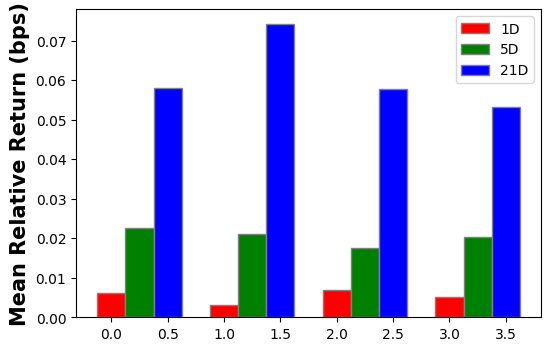

In [9]:
barWidth = 0.25
fig = plt.subplots(figsize =(6, 4))
br1 = np.arange(len(one_day_returns)) 
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.bar(br1, one_day_returns, color ='r', width = barWidth, edgecolor ='grey', label ='1D') 
plt.bar(br2, five_day_returns, color ='g', width = barWidth, edgecolor ='grey', label ='5D') 
plt.bar(br3, twentyone_day_returns, color ='b', width = barWidth, edgecolor ='grey', label ='21D')
plt.ylabel('Mean Relative Return (bps)', fontweight ='bold', fontsize = 15) 
plt.legend()
plt.show()

In [10]:
# Second, assuming profitability growth is predictive, how does it relate to profitability?
fundamentals["is_profitable"] = 1
fundamentals.loc[fundamentals["operating_margin_c"] < 0, "is_profitable"] = 0

([<matplotlib.patches.Wedge at 0x7fa3999b3a60>,
 [Text(-1.0823225495601467, 0.19641257269743193, 'True'),
  Text(1.0823225518588306, -0.1964125600306379, 'False')])

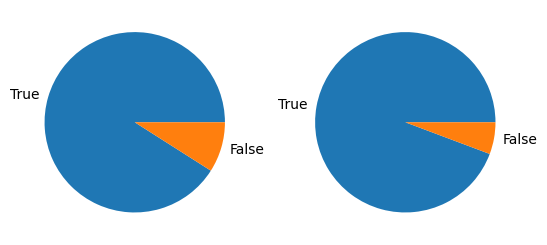

In [12]:
negative_opermargin = fundamentals[fundamentals["operating_margin_growth"] <= 0]
twenty_five_percentile = np.nanpercentile(negative_opermargin["operating_margin_growth"], 50)

positive_opermargin = fundamentals[fundamentals["operating_margin_growth"] > 0]
seventy_five_percentile = np.nanpercentile(positive_opermargin["operating_margin_growth"], 50)

first_quantile = negative_opermargin[negative_opermargin["operating_margin_growth"] <= twenty_five_percentile]
forth_quantile = positive_opermargin[positive_opermargin["operating_margin_growth"] > seventy_five_percentile]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie([first_quantile[first_quantile["is_profitable"] == 1].shape[0], first_quantile[first_quantile["is_profitable"] == 0].shape[0]], labels=["True", "False"])
ax2.pie([forth_quantile[forth_quantile["is_profitable"] == 1].shape[0], forth_quantile[forth_quantile["is_profitable"] == 0].shape[0]], labels=["True", "False"])
# We see that it is better to own an unprofitable company that's getting better than a profitable company that's getting worse.
# This suggests that profitability growth is a more reliable indicator of future performance among profitable companies than among unprofitable companies. 

In [18]:
corr = fundamentals[["operating_margin_growth", "OneDRet"]].corr()

In [19]:
corr

,operating_margin_growth,OneDRet
operating_margin_growth,1.000,-0.038
OneDRet,-0.038,1.000


In [ ]:
# My third question is how the profitability growth factor interacts with the size factor.